<a href="https://colab.research.google.com/github/aojedanu/PRACTICA_GIT./blob/main/Clasificador_cerebros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader


# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)


100%|██████████| 86.8M/86.8M [00:04<00:00, 18.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Cambiar tamaño si es necesario
    transforms.ToTensor(),  # Convertir imágenes en Tensores
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizar imágenes en escala de grises
])

dataset = datasets.ImageFolder(root=path, transform=transform)

# Dividir datos en entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Guardar en variables
train = train_loader
test = test_loader

print("Datos de entrenamiento y prueba listos")

Datos de entrenamiento y prueba listos


In [3]:


class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)  # Entrada: 1 canal (blanco y negro), Salida: 16 canales
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con kernel 2x2
        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 16 canales, Salida: 32 canales

        # Capa totalmente conectada
        self.fc1 = nn.Linear(32 * 32 * 32, 120)  # Ajustado para 32x32 dimensiones
        self.fc2 = nn.Linear(120, num_classes)  # 4 categorías en la salida

    def forward(self, x):
        # Primera convolución y pooling
        x = self.pool(F.relu(self.conv1(x)))
        #print(f"Después de conv1 y pooling: {x.shape}")  # (batch_size, 16, 64, 64)
        # Segunda convolución y pooling
        x = self.pool(F.relu(self.conv2(x)))
        #print(f"Después de conv2 y pooling: {x.shape}")  # (batch_size, 32, 32, 32)
        # Aplanar el tensor para la capa totalmente conectada
        x = x.view(-1, 32 * 32 * 32)  # Cambiado para imágenes de 128x128
        #print(f"Después de aplanar: {x.shape}")  # (batch_size, 32 * 32 * 32)
        # Primera capa totalmente conectada
        x = F.relu(self.fc1(x))
        #print(f"Después de fc1: {x.shape}")  # (batch_size, 120)
        # Salida final
        x = self.fc2(x)
        return x



In [4]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Inspeccionar el primer lote
data_iter = iter(dataloader)
images, labels = next(data_iter)

print(f"Forma del tensor: {images.shape}")

Forma del tensor: torch.Size([1, 3, 128, 128])


In [5]:

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos

        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 0.3712930061468264
Epoch 2, Loss: 0.2939062220294301
Epoch 3, Loss: 0.2753560881062252
Epoch 4, Loss: 0.2500504504253225
Epoch 5, Loss: 0.22465485788700057
Epoch 6, Loss: 0.1978301960157185
Epoch 7, Loss: 0.18292783982143168
Epoch 8, Loss: 0.17026854088393653
Epoch 9, Loss: 0.16816613968552613
Epoch 10, Loss: 0.152085328247489


In [6]:
correct = 0
total = 0
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')

Accuracy of the model on the 10000 test images: 86.52373660030628%


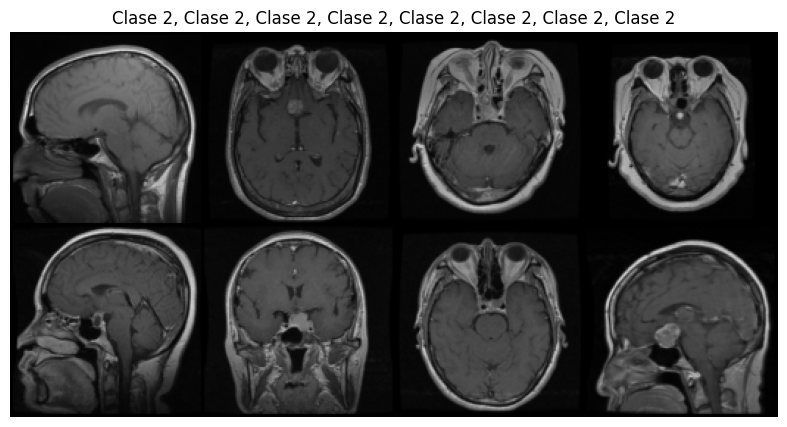

In [7]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Función para visualizar imágenes del DataLoader
def visualize_dataset(dataloader, class_names, num_images=8):
    """
    Muestra un conjunto de imágenes con sus etiquetas.

    Args:
        dataloader: DataLoader con el dataset.
        class_names: Lista de nombres de las clases.
        num_images: Número de imágenes a mostrar.
    """
    # Obtener un batch de imágenes
    images, labels = next(iter(dataloader))

    # Seleccionar solo las primeras `num_images` imágenes
    images = images[:num_images]
    labels = labels[:num_images]

    # Desnormalizar las imágenes (si fueron normalizadas)
    images = images * 0.5 + 0.5  # Deshacer Normalización (-1 a 1 => 0 a 1)

    # Crear un grid de imágenes
    grid_img = make_grid(images, nrow=4, padding=2)
    np_grid = grid_img.numpy().transpose((1, 2, 0))  # Convertir a formato de Matplotlib

    # Mostrar las imágenes
    plt.figure(figsize=(10, 5))
    plt.imshow(np_grid)
    plt.axis('off')

    # Mostrar etiquetas
    labels_text = [class_names[label] for label in labels]
    plt.title(", ".join(labels_text), fontsize=12)
    plt.show()

class_names = ["Clase 1", "Clase 2", "Clase 3", "Clase 4"]  # Cambia esto por las clases reales
visualize_dataset(train_loader, class_names)

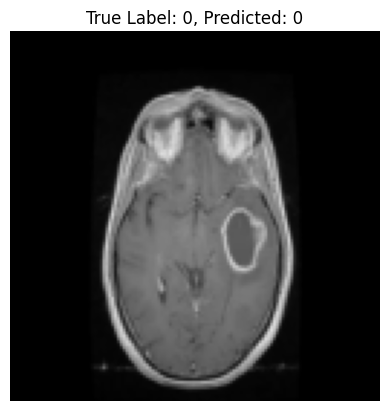

True Label: 0
Predicted Label: 0


In [25]:
# Obtener un lote de imágenes y etiquetas
# Obtener un lote de imágenes y etiquetas
data_iter = iter(train)  # Convertir el DataLoader en un iterador
images, labels = next(data_iter)

# Elegir una imagen aleatoria
random_index = random.randint(0, len(images) - 1)
image = images[random_index]  # Tensor con forma (C, H, W)
label = labels[random_index]

# Desnormalizar la imagen
image = image * 0.5 + 0.5  # Revertir normalización: image = image * std + mean

# Verificar si la imagen tiene múltiples canales (C > 1)
if image.shape[0] == 3:  # Caso RGB con forma (3, H, W)
    image_np = image.permute(1, 2, 0).numpy()  # Cambiar a (H, W, C) para matplotlib
elif image.shape[0] == 1:  # Caso escala de grises con forma (1, H, W)
    image_np = image.squeeze(0).numpy()  # Reducir a (H, W)
else:
    raise ValueError(f"Forma inesperada de la imagen: {image.shape}")

# Realizar la predicción
model.eval()  # Establecer el modelo en modo evaluación
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    output = model(image.unsqueeze(0))  # Agregar la dimensión de batch
    _, predicted = torch.max(output.data, 1)  # Obtener la clase predicha

# Mostrar la imagen y la predicción
plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)  # Usar cmap si es escala de grises
plt.title(f'True Label: {label.item()}, Predicted: {predicted.item()}')
plt.axis('off')  # Ocultar los ejes
plt.show()

# Imprimir los valores
print(f'True Label: {label.item()}')
print(f'Predicted Label: {predicted.item()}')

